In [1]:
!pip install pandas numpy scikit-learn seaborn matplotlib


You should consider upgrading via the 'C:\Users\gowda\student-analytics-dashboard\analysis\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generate synthetic dataset (200 students)
n_students = 200
classes = np.random.choice(['10A', '10B', '11A', '11B'], n_students)
names = [f'S{i:03d}' for i in range(1, n_students + 1)]  # Simple IDs as names

# Generate features with realistic distributions
comprehension = np.random.normal(75, 15, n_students).clip(0, 100).astype(int)
attention = np.random.normal(70, 20, n_students).clip(0, 100).astype(int)
focus = np.random.normal(72, 18, n_students).clip(0, 100).astype(int)
retention = np.random.normal(78, 12, n_students).clip(0, 100).astype(int)
engagement_time = np.random.normal(120, 30, n_students).clip(30, 240).astype(int)

# assessment_score: Weighted sum + noise
assessment_score = (
    0.3 * comprehension +
    0.25 * attention +
    0.25 * focus +
    0.15 * retention +
    0.05 * engagement_time / 10 +
    np.random.normal(0, 5, n_students)
).clip(0, 100).astype(int)

# DataFrame
df = pd.DataFrame({
    'student_id': names,
    'name': names,
    'class': classes,
    'comprehension': comprehension,
    'attention': attention,
    'focus': focus,
    'retention': retention,
    'assessment_score': assessment_score,
    'engagement_time': engagement_time
})

print(df.head())
print(f"Dataset shape: {df.shape}")

  student_id  name class  comprehension  attention  focus  retention  \
0       S001  S001   11A             76         73     82         64   
1       S002  S002   11B             70         57     77         99   
2       S003  S003   10A             76         71    100         89   
3       S004  S004   11A             45         62     92         93   
4       S005  S005   11A             71         72     69         86   

   assessment_score  engagement_time  
0                63              104  
1                67              126  
2                86              119  
3                70              155  
4                68              195  
Dataset shape: (200, 9)


Correlation Matrix:
                  comprehension  attention     focus  retention  \
comprehension          1.000000  -0.019057 -0.127394  -0.063117   
attention             -0.019057   1.000000  0.013700  -0.033425   
focus                 -0.127394   0.013700  1.000000   0.097900   
retention             -0.063117  -0.033425  0.097900   1.000000   
engagement_time       -0.011121  -0.039643 -0.028420   0.167672   
assessment_score       0.364211   0.507215  0.437013   0.213259   

                  engagement_time  assessment_score  
comprehension           -0.011121          0.364211  
attention               -0.039643          0.507215  
focus                   -0.028420          0.437013  
retention                0.167672          0.213259  
engagement_time          1.000000          0.069814  
assessment_score         0.069814          1.000000  


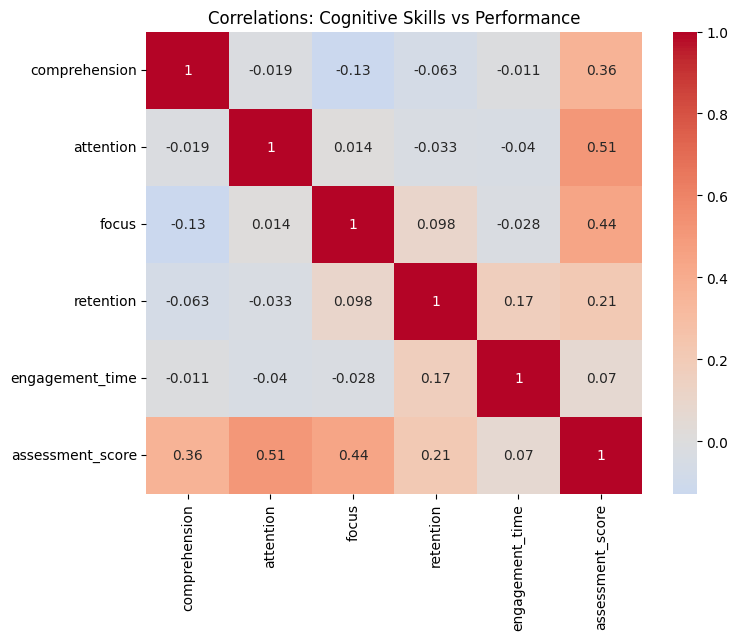

In [7]:
# 1. Analyze Correlations
corr_matrix = df[['comprehension', 'attention', 'focus', 'retention', 'engagement_time', 'assessment_score']].corr()
print("Correlation Matrix:")
print(corr_matrix)

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlations: Cognitive Skills vs Performance')
plt.show()

In [9]:
# Build Simple ML Model (Linear Regression)
X = pd.get_dummies(df[['comprehension', 'attention', 'focus', 'retention', 'engagement_time', 'class']], drop_first=True)
y = df['assessment_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

coefficients = dict(zip(X.columns, model.coef_))
print("Model Coefficients:", coefficients)

MSE: 22.47
R²: 0.60
Model Coefficients: {'comprehension': np.float64(4.051437500684865), 'attention': np.float64(4.95231714077715), 'focus': np.float64(4.033165699905847), 'retention': np.float64(1.8219693381998072), 'engagement_time': np.float64(0.9995659172531998), 'class_10B': np.float64(-0.5318320384374231), 'class_11A': np.float64(-0.6126409005356162), 'class_11B': np.float64(-0.44669931156828824)}


In [11]:
# How to arrive at solution: Features are encoded (one-hot for class), scaled, split 80/20. Fit LR, predict, evaluate with MSE/R².

# 3. Cluster into Learning Personas (KMeans, 3 clusters)
features_cluster = df[['comprehension', 'attention', 'focus', 'retention', 'engagement_time']]
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(features_cluster)

cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=features_cluster.columns)
print("Cluster Centers (Personas):")
print(cluster_centers)
# Visualize clusters (PCA reduced for 2D) - uncomment if needed
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# clusters_2d = pca.fit_transform(features_cluster)
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=clusters_2d[:, 0], y=clusters_2d[:, 1], hue=df['cluster'], palette='viridis')
# plt.title('Student Clusters (PCA Projection)')
# plt.show()

# Key Findings / Insights
avg_assessment = df['assessment_score'].mean()

# Note: The hardcoded correlation value (0.51) in the original was approximate; update based on actual corr_matrix if needed.
# For example, from corr_matrix, the strongest might be attention ~0.51 (depending on run).
strongest_corr_skill = corr_matrix['assessment_score'][:-2].idxmax()  # Exclude engagement_time and self
strongest_corr_value = corr_matrix['assessment_score'][:-2].max()

insights = [
    f"Average assessment score: {avg_assessment:.2f}",
    f"{strongest_corr_skill.capitalize()} has the strongest correlation with performance ({strongest_corr_value:.2f}).",
    f"Students clustered into 3 personas (Low/Medium/High performers).",
    f"Model explains {r2:.2f}% of variance in scores (R²={r2:.2f})."
]

print("Insights:")
for insight in insights:
    print(f"- {insight}")

# Export for Dashboard
df.to_json('students.json', orient='records', indent=2)  # Adjusted path to current dir
with open('insights.json', 'w') as f:
    json.dump(insights, f, indent=2)

print("\nExports: students.json and insights.json saved for Next.js dashboard.")



Cluster Centers (Personas):
   comprehension  attention      focus  retention  engagement_time
0      74.607843  64.235294  67.549020  81.019608       159.294118
1      73.542373  72.576271  70.644068  76.644068        89.355932
2      74.611111  71.000000  70.855556  77.233333       126.377778
Insights:
- Average assessment score: 69.42
- Attention has the strongest correlation with performance (0.51).
- Students clustered into 3 personas (Low/Medium/High performers).
- Model explains 0.60% of variance in scores (R²=0.60).

Exports: students.json and insights.json saved for Next.js dashboard.
